In [1]:
import requests
import json
import os
from pathlib import Path

from tqdm import tqdm

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import ffmpeg

from mrcnn import visualize
import mrcnn.model as modellib

import lego

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.5.1'

In [2]:
import os
from PIL import Image, ImageDraw, ImageFont

def render_detections(image, boxes, masks, class_ids, scores, class_names, image_name=None, filter_classs_names=None,
               scores_thresh=0.1, save_dir=None, mode=0):
    """
        image: image array
        image_name: image name
        boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
        masks: [num_instances, height, width]
        class_ids: [num_instances]
        scores: confidence scores for each box
        class_names: list of class names of the dataset
        filter_classs_names: (optional) list of class names we want to draw
        scores_thresh: (optional) threshold of confidence scores
        save_dir: (optional) the path to store image
        mode: (optional) select the result which you want
                mode = 0 , save image with bbox,class_name,score and mask;
                mode = 1 , save image with bbox,class_name and score;
                mode = 2 , save image with class_name,score and mask;
                mode = 3 , save mask with black background;
    """
    mode_list = [0, 1, 2, 3]
    assert mode in mode_list, "mode's value should in mode_list %s" % str(mode_list)

    if save_dir is None and image_name is not None:
        save_dir = os.path.join(os.getcwd(), "output")
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

    useful_mask_indices = []

    N = boxes.shape[0]
    if not N:
        print("\n*** No instances in image %s to draw *** \n" % (image_name))
        return
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    for i in range(N):
        # filter
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        if score is None or score < scores_thresh:
            continue

        label = class_names[class_id]
        if (filter_classs_names is not None) and (label not in filter_classs_names):
            continue

        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue

        useful_mask_indices.append(i)

    if len(useful_mask_indices) == 0:
        print("\n*** No instances in image %s to draw *** \n" % (image_name))
        return

    colors = visualize.random_colors(len(useful_mask_indices))

    if mode != 3:
        masked_image = image.astype(np.uint8).copy()
    else:
        masked_image = np.zeros(image.shape).astype(np.uint8)

    if mode != 1:
        for index, value in enumerate(useful_mask_indices):
            masked_image = visualize.apply_mask(masked_image, masks[:, :, value], colors[index])

    masked_image = Image.fromarray(masked_image)

    if mode == 3:
        if image_name is not None:
            masked_image.save(os.path.join(save_dir, '%s.jpg' % (image_name)))
        return masked_image

    draw = ImageDraw.Draw(masked_image)
    colors = np.array(colors).astype(int) * 255

    for index, value in enumerate(useful_mask_indices):
        class_id = class_ids[value]
        score = scores[value]
        label = class_names[class_id]

        y1, x1, y2, x2 = boxes[value]
        if mode != 2:
            color = tuple(colors[index])
            draw.rectangle((x1, y1, x2, y2), outline=color)

        # Label
        # font = ImageFont.truetype('/Library/Fonts/Arial.ttf', 15)
        # draw.text((x1, y1), "%s %f" % (label, score), (255, 255, 255), font)
        draw.text((x1, y1), "%s %f" % (label, score), (255, 255, 255))

    if image_name is not None:
        masked_image.save(os.path.join(save_dir, '%s.jpg' % (image_name)))
    return masked_image

In [3]:
REPO_URL = 'https://api.github.com/repos/LilDataMonster/Lego-CNN/releases/latest'
response = json.loads(requests.get(REPO_URL).text)

In [4]:
LEGO_WEIGHTS_URL = response['assets'][0]['browser_download_url']
LEGO_WEIGHTS_NAME = os.path.basename(LEGO_WEIGHTS_URL)

LEGO_WEIGHTS_PATH = Path(os.path.join('.', LEGO_WEIGHTS_NAME))

weights_response = requests.get(LEGO_WEIGHTS_URL, stream=True)
total_size_in_bytes= int(weights_response.headers.get('content-length', 0))
progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
if not LEGO_WEIGHTS_PATH.exists():
    # Streaming, so we can iterate over the response.
    block_size = 1024 #1 Kibibyte
    with open(LEGO_WEIGHTS_NAME, 'wb') as file:
        for data in weights_response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)

    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR downloading pretrained weights")
progress_bar.close()

  0%|          | 0.00/262M [00:00<?, ?iB/s]


In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [6]:
class InferenceConfig(lego.LegoConfig().__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

In [7]:
# # Directory to save logs and trained model
# MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# LEGO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "snapshots", "weights","mask_rcnn_lego_0111.h5") # Comment out to use snapshot from latest training

model = modellib.MaskRCNN(mode="inference", model_dir="", config=config)
print("Loading weights ", LEGO_WEIGHTS_PATH)
model.load_weights(LEGO_WEIGHTS_PATH, by_name=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead
Loading weights  mask_rcnn_lego_0200.h5


In [8]:
# dataset = lego.LegoDataset()
# dataset.prepare()
#dataset.class_names
class_names = ['BG', '2431', '3003', '3005', '3010', '3020', '3021', '3022', '3023', '3024', '3069', '3070', '3176', '3622', '3700', '3710', '3958', '4150', '4274', '6141', '11211', '11476', '11477', '15068', '15573', '22885', '24201', '24246', '25269', '29119', '29120', '33909', '35480', '36840', '47458', '47905', '85984', '87079', '87087', '87580', '93273', '98138', '99206']

In [9]:
from tqdm import tqdm
from cv2 import CAP_PROP_FRAME_COUNT

def frame_iter(capture, description):
    def _iterator():
        while capture.grab():
            yield capture.retrieve()[1]
    return tqdm(
        _iterator(),
        desc=description,
        total=int(capture.get(CAP_PROP_FRAME_COUNT)),
    )

In [10]:
# video_filename = 'movie.mp4'
# cap = cv2.VideoCapture(video_filename)
# frame_width = int(cap.get(3))
# frame_height = int(cap.get(4))

# detect_video_filename = 'detect_' + video_filename
# out = cv2.VideoWriter(detect_video_filename, cv2.VideoWriter_fourcc('M','J','P','G'), 60, (frame_width,frame_height))

# for frame in frame_iter(cap, detect_video_filename):
#     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     results = model.detect([frame], verbose=0)[0]
    
#     frame_detect = render_detections(frame, results['rois'], results['masks'], results['class_ids'], results['scores'], class_names, filter_classs_names=None, scores_thresh=0.1, save_dir=None, mode=0)
#     frame_detect = np.array(frame_detect)
    
#     frame_detect = cv2.cvtColor(frame_detect, cv2.COLOR_RGB2BGR)
#     out.write(frame_detect)
    
#     # plt.figure()
#     # plt.imshow(frame_detect)
#     # plt.show()
    
# cap.release()    
# out.release()

In [11]:
image_path = '000000.jpg'
# image = tf.keras.preprocessing.image.load_img(image_path)
# image_data = tf.keras.preprocessing.image.img_to_array(image)
image_data = cv2.imread(image_path)
results = model.detect([image_data], verbose=0)[0]
# results

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [12]:
output_image = render_detections(image_data, results['rois'], results['masks'], results['class_ids'], results['scores'], class_names, filter_classs_names=None, scores_thresh=0.1, save_dir=None, mode=0)

In [13]:
results.keys()

dict_keys(['rois', 'class_ids', 'scores', 'masks'])

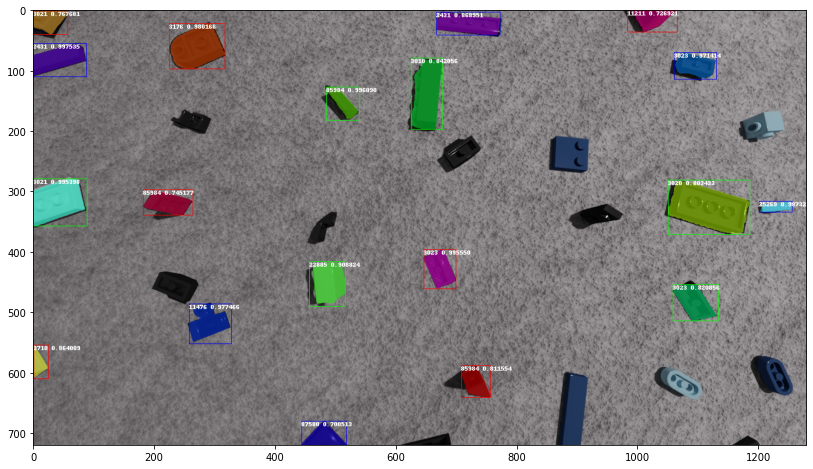

In [14]:
plt.figure(figsize=(16,8))
plt.imshow(output_image)

In [15]:
# ax = get_ax(1)
# visualize.display_instances(image_data, results['rois'], results['masks'], results['class_ids'], class_names, results['scores'], ax=ax, title="Predictions")

In [16]:
from deep_sort import preprocessing
from deep_sort import nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker
from deep_sort import generate_detections

In [17]:
# model_feature = 'mars-small128.pb'
model_feature = 'market1501.pb'
min_score = 0.7

encoder = generate_detections.create_box_encoder(model_feature, batch_size=1)
metric = nn_matching.NearestNeighborDistanceMetric("cosine", min_score, None)
tracker = Tracker(metric)

In [18]:
colors = visualize.random_colors(len(class_names))
colors = (np.array(colors).astype(float) * 255).astype(int)

In [19]:
boxes = results['rois']
masks = results['masks']
class_ids = results['class_ids']
classes_scores = results['scores']

N = boxes.shape[0]
return_boxes = []
return_scores = []
return_masks = []
return_class_names = []
return_class_color = []

x_factor = 64/720
y_factor = 120/1280
for i in range(N):
    class_id = class_ids[i]
    classes_score = classes_scores[i]

    if classes_score < min_score: continue

    return_scores.append(classes_score)
    y1, x1, y2, x2 = boxes[i]                
    return_boxes.append([np.uint8(x1*x_factor), np.uint8(y1*y_factor), np.uint8((x2 - x1)*x_factor), np.uint8((y2 - y1)*y_factor)])
    return_masks.append(masks[:, :, i])
    return_class_names.append(class_names[class_id])
    return_class_color.append(colors[i])

In [20]:
np.shape(image_data)

(720, 1280, 3)

In [21]:
np.shape(return_boxes)

(19, 4)

In [22]:
# image_data_rs = cv2.resize(image_data, (128,64), interpolation = cv2.INTER_AREA)
# print(np.shape(image_data_rs))

In [23]:
# results['class_colors'] = [colors[cid] for cid in results['class_ids']]

features = encoder(image_data, return_boxes)
# detections = []
# for bbox, score, classe, mask, color, featurein zip(results['rois'], results['scores'], results['class_ids'], results['masks'], results['class_colors'], features):
#     detections.append(Detection(bbox, score, classe, mask, color, feature))

TypeError: float() argument must be a string or a number, not 'NoneType'

In [49]:
import tensorflow.compat.v1 as tf
class ImageEncoder1(object):

    def __init__(self, checkpoint_filename, input_name="images", output_name="features"):
        self.session = tf.Session()
        with tf.gfile.GFile(checkpoint_filename, "rb") as file_handle:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(file_handle.read())
        tf.import_graph_def(graph_def)
        try:
            self.input_var = tf.get_default_graph().get_tensor_by_name(input_name)
            self.output_var = tf.get_default_graph().get_tensor_by_name(output_name)
        except KeyError:
            layers = [i.name for i in tf.get_default_graph().get_operations()]
            self.input_var = tf.get_default_graph().get_tensor_by_name(layers[0]+':0')
            self.output_var = tf.get_default_graph().get_tensor_by_name(layers[-1]+':0')            

        assert len(self.output_var.get_shape()) == 2
        assert len(self.input_var.get_shape()) == 4
        self.feature_dim = self.output_var.get_shape().as_list()[-1]
        self.image_shape = self.input_var.get_shape().as_list()[1:]
        print(self.input_var)

    def __call__(self, data_x, batch_size=32):
        out = np.zeros((len(data_x), self.feature_dim), np.float32)
        _run_in_batches(
            lambda x: self.session.run(self.output_var, feed_dict=x),
            {self.input_var: data_x}, out, batch_size)
        return out

In [61]:
def extract_image_patch1(image, bbox, patch_shape):
    """Extract image patch from bounding box.

    Parameters
    ----------
    image : ndarray
        The full image.
    bbox : array_like
        The bounding box in format (x, y, width, height).
    patch_shape : Optional[array_like]
        This parameter can be used to enforce a desired patch shape
        (height, width). First, the `bbox` is adapted to the aspect ratio
        of the patch shape, then it is clipped at the image boundaries.
        If None, the shape is computed from :arg:`bbox`.

    Returns
    -------
    ndarray | NoneType
        An image patch showing the :arg:`bbox`, optionally reshaped to
        :arg:`patch_shape`.
        Returns None if the bounding box is empty or fully outside of the image
        boundaries.

    """
    bbox = np.array(bbox)
    if patch_shape is not None:
        # correct aspect ratio to patch shape
        target_aspect = float(patch_shape[1]) / patch_shape[0]
        new_width = target_aspect * bbox[3]
        bbox[0] -= (new_width - bbox[2]) / 2
        bbox[2] = new_width

    # convert to top left, bottom right
    bbox[2:] += bbox[:2]
    bbox = bbox.astype(np.int)

    # clip at image boundaries
    bbox[:2] = np.maximum(0, bbox[:2])
    bbox[2:] = np.minimum(np.asarray(image.shape[:2][::-1]) - 1, bbox[2:])
    if np.any(bbox[:2] >= bbox[2:]):
        return None
    sx, sy, ex, ey = bbox
    image = image[sy:ey, sx:ex]
    # image = cv2.resize(image, tuple(patch_shape[::-1]))
    return image

In [62]:
def create_box_encoder1(model_filename, input_name="images:0", output_name="features:0", batch_size=32):
    image_encoder = ImageEncoder1(model_filename, input_name, output_name)
    image_shape = image_encoder.image_shape

    def encoder(image, boxes):
        image_patches = []
        print(image_shape)
        for box in boxes:
            # patch = extract_image_patch1(image, box, image_shape[:2])
            patch = extract_image_patch1(image, box, None)
            if patch is None:
                print("WARNING: Failed to extract image patch: %s." % str(box))
                patch = np.random.uniform(0., 255., image_shape).astype(np.uint8)
            image_patches.append(patch)
        image_patches = np.asarray(image_patches)
        return image_encoder(image_patches, batch_size)

    return encoder

In [66]:
def _run_in_batches(f, data_dict, out, batch_size):
    data_len = len(out)
    num_batches = int(data_len / batch_size)

    s, e = 0, 0
    for i in range(num_batches):
        s, e = i * batch_size, (i + 1) * batch_size
        batch_data_dict = {k: v[s:e] for k, v in data_dict.items()}
        out[s:e] = f(batch_data_dict)
    if e < len(out):
        batch_data_dict = {k: v[e:] for k, v in data_dict.items()}
        out[e:] = f(batch_data_dict)

In [71]:
encoder = create_box_encoder1(model_feature, batch_size=1)


Tensor("input_image:0", shape=(None, None, None, 3), dtype=float32)


In [72]:
encoder

<function __main__.create_box_encoder1.<locals>.encoder(image, boxes)>

In [73]:
features = encoder(image_data, return_boxes)

[None, None, 3]


ValueError: setting an array element with a sequence.